In [1]:
!pip install ultralytics
!pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.6 MB/s eta 0:00:00
   ━━━━

In [ ]:
import os
import json
import cv2
import copy
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import yaml
import gc
from collections import defaultdict

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

PyTorch version: 2.6.0+cu124
CUDA available: True
Number of GPUs: 2
GPU 0: Tesla T4
GPU 1: Tesla T4


In [ ]:
class Config:
    # Paths
    DATASET_DIR = '/kaggle/input/raw-data/train'
    OUTPUT_DIR = '/kaggle/working/yolomaml_output'

    # Model
    BASE_MODEL = 'yolo11n.pt'
    IMG_SIZE = 640

    # Meta-Learning Parameters
    META_BATCH_SIZE = 2
    N_SUPPORT = 3
    N_QUERY = 5

    # Training
    META_EPOCHS = 50
    INNER_STEPS = 3
    META_LR = 0.0005
    INNER_LR = 0.01

    # Data split
    META_TRAIN_RATIO = 0.8

    # Device
    USE_MULTI_GPU = True
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Checkpointing
    SAVE_FREQ = 5

    # Memory optimization
    GRADIENT_ACCUMULATION_STEPS = 4
    MIXED_PRECISION = True

cfg = Config()
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
def load_and_preprocess_image(img_path, img_size=640):
    """Load and preprocess image"""
    try:
        img = cv2.imread(str(img_path))
        if img is None:
            return None

        if len(img.shape) != 3 or img.shape[2] != 3:
            return None

        # Convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize
        img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_LINEAR)

        # Normalize directly with torch
        img_tensor = torch.from_numpy(img).float().div(255.0).permute(2, 0, 1)

        return img_tensor

    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None


def extract_frame(video_path, frame_num, img_size=640):
    """Extract specific frame from video"""
    try:
        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = cap.read()
        cap.release()

        if not ret or frame is None:
            return None, None

        if len(frame.shape) != 3 or frame.shape[2] != 3:
            return None, None

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        h, w = frame.shape[:2]

        # Resize
        frame = cv2.resize(frame, (img_size, img_size), interpolation=cv2.INTER_LINEAR)

        # Normalize directly with torch
        frame_tensor = torch.from_numpy(frame).float().div(255.0).permute(2, 0, 1)

        return frame_tensor, (w, h)

    except Exception as e:
        print(f"Error extracting frame: {e}")
        return None, None


def convert_bbox_to_yolo(bbox, orig_w, orig_h, img_size=640):
    """Convert bbox to YOLO format (normalized)"""
    x1, y1, x2, y2 = bbox

    scale_x = img_size / orig_w
    scale_y = img_size / orig_h

    x1 = x1 * scale_x
    y1 = y1 * scale_y
    x2 = x2 * scale_x
    y2 = y2 * scale_y

    x_center = (x1 + x2) / 2.0 / img_size
    y_center = (y1 + y2) / 2.0 / img_size
    width = (x2 - x1) / img_size
    height = (y2 - y1) / img_size

    # Clamp to valid range
    x_center = np.clip(x_center, 0, 1)
    y_center = np.clip(y_center, 0, 1)
    width = np.clip(width, 0, 1)
    height = np.clip(height, 0, 1)

    return torch.tensor([x_center, y_center, width, height])

In [ ]:
class MetaTaskDataset:
    """Organizes data into meta-learning tasks"""

    def __init__(self, base_dir, annotations_file, img_size=640):
        self.base_dir = base_dir
        self.img_size = img_size
        self.tasks = []

        print("Loading annotations...")
        with open(annotations_file, 'r') as f:
            annotations = json.load(f)

        print("Preparing meta-tasks...")
        for record in tqdm(annotations, desc="Processing videos"):
            video_id = record['video_id']
            video_dir = os.path.join(base_dir, 'samples', video_id)

            # Load reference images
            ref_dir = os.path.join(video_dir, 'object_images')
            if not os.path.exists(ref_dir):
                continue

            ref_images = []
            for img_name in ['img_1.jpg', 'img_2.jpg', 'img_3.jpg']:
                img_path = os.path.join(ref_dir, img_name)
                if os.path.exists(img_path):
                    ref_images.append(img_path)

            if len(ref_images) < 3:
                continue

            # Get video path
            video_path = os.path.join(video_dir, 'drone_video.mp4')
            if not os.path.exists(video_path):
                continue

            # Collect annotated frames
            query_samples = []
            for interval in record.get('annotations', []):
                for bbox_data in interval.get('bboxes', []):
                    frame_num = bbox_data['frame']
                    box = [
                        bbox_data['x1'],
                        bbox_data['y1'],
                        bbox_data['x2'],
                        bbox_data['y2']
                    ]
                    query_samples.append({
                        'video_path': video_path,
                        'frame_num': frame_num,
                        'bbox': box
                    })

            if len(query_samples) < 5:
                continue

            task = {
                'video_id': video_id,
                'support_images': ref_images,
                'query_samples': query_samples
            }
            self.tasks.append(task)

        print(f"Created {len(self.tasks)} valid tasks")

    def __len__(self):
        return len(self.tasks)

    def __getitem__(self, idx):
        return self.tasks[idx]

In [ ]:
from ultralytics import YOLO

class YOLOFeatureExtractor(nn.Module):
    """Extract features from YOLO backbone"""

    def __init__(self, base_model_path='yolo11n.pt', device='cuda'):
        super().__init__()
        self.device = device

        # Load YOLO model
        yolo = YOLO(base_model_path)
        self.model = yolo.model.to(device)

        # Freeze early layers
        for i, (name, param) in enumerate(self.model.named_parameters()):
            if i < 10:  # Freeze first 10 layers
                param.requires_grad = False

    def forward(self, x):
        return self.model(x)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
class MAMLDetectionHead(nn.Module):
    """Learnable detection head for MAML"""

    def __init__(self, in_channels=144, num_anchors=3):  # changed from 256 to 144
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, 256, 3, padding=1)
        self.conv2 = nn.Conv2d(256, 128, 3, padding=1)

        # Bbox regression + objectness
        self.bbox_pred = nn.Conv2d(128, num_anchors * 4, 1)
        self.obj_pred = nn.Conv2d(128, num_anchors * 1, 1)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        bbox = self.bbox_pred(x)
        obj = self.obj_pred(x)

        return bbox, obj

In [ ]:
"""
Prototypical Networks: simpler few-shot route that learns embeddings and
classifies by distance to a prototype, easier to train than MAML here.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
from tqdm.auto import tqdm
import gc

class PrototypicalYOLO(nn.Module):
    """
    Few-shot detector that freezes the YOLO backbone and learns
    prototypical embedding/detection heads.
    """

    def __init__(self, base_model_path='yolo11n.pt', device='cuda'):
        super().__init__()
        self.device = device

        # Feature extractor
        from ultralytics import YOLO
        yolo = YOLO(base_model_path)
        self.backbone = yolo.model.to(device)

        # Freeze backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Embedding head (project features to metric space)
        self.embedding_head = nn.Sequential(
            nn.Conv2d(144, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 1),  # Embedding dimension = 128
        ).to(device)

        # Detection head (same structure as baseline)
        self.bbox_head = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 4, 1)  # 4 coords
        ).to(device)

        self.obj_head = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 1)  # Objectness
        ).to(device)

    def extract_features(self, x):
        """Extract backbone features."""
        self.backbone.train()

        with torch.no_grad():
            features = self.backbone(x)
            if isinstance(features, (list, tuple)):
                features = features[0]
        return features

    def forward(self, x, return_embeddings=False):
        """
        Forward pass.

        Args:
            x: [B, 3, H, W]
            return_embeddings: if True, return embeddings instead of detections

        Returns:
            embeddings: [B, 128, H/32, W/32] or
            (bbox, obj): predictions
        """
        # Extract features
        features = self.extract_features(x)  # [B, 144, H/32, W/32]

        # Get embeddings
        embeddings = self.embedding_head(features)  # [B, 128, H/32, W/32]

        if return_embeddings:
            return embeddings

        # Detection
        bbox = self.bbox_head(embeddings)
        obj = self.obj_head(embeddings)

        return bbox, obj

    def compute_prototype(self, support_imgs, support_bboxes):
        """
        Build a class prototype from the support set.

        Args:
            support_imgs: [N, 3, H, W]
            support_bboxes: [N, 4] normalized xywh

        Returns:
            prototype: [128] embedding vector for the target object
        """
        embeddings = self.forward(support_imgs, return_embeddings=True)
        # [N, 128, H', W']

        # RoI pooling: grab embeddings in the bbox region
        N, C, H, W = embeddings.shape

        roi_embeddings = []
        for i in range(N):
            x_c, y_c, w, h = support_bboxes[i]

            # Convert to grid coords
            x_c = int(x_c * W)
            y_c = int(y_c * H)
            w = max(1, int(w * W))
            h = max(1, int(h * H))

            x1 = max(0, x_c - w//2)
            y1 = max(0, y_c - h//2)
            x2 = min(W, x_c + w//2)
            y2 = min(H, y_c + h//2)

            # Average pooling within the RoI
            roi = embeddings[i, :, y1:y2, x1:x2]  # [128, h, w]
            roi_feat = roi.mean(dim=[1, 2])  # [128]
            roi_embeddings.append(roi_feat)

        # Prototype is the mean of support embeddings
        prototype = torch.stack(roi_embeddings).mean(dim=0)  # [128]

        return prototype

    def compute_loss_with_prototype(self, query_imgs, query_targets, prototype):
        """
        Loss tying detections to a class prototype.

        Args:
            query_imgs: [B, 3, H, W]
            query_targets: [B, 4]
            prototype: [128] target embedding

        Returns:
            loss: scalar
        """
        # Get predictions
        bbox_pred, obj_pred = self.forward(query_imgs)

        # Get embeddings
        embeddings = self.forward(query_imgs, return_embeddings=True)
        # [B, 128, H', W']

        B, C, H, W = embeddings.shape

        # Reshape
        bbox_pred = bbox_pred.permute(0, 2, 3, 1).reshape(B, -1, 4)
        obj_pred = obj_pred.permute(0, 2, 3, 1).reshape(B, -1)
        embeddings = embeddings.permute(0, 2, 3, 1).reshape(B, -1, C)

        # Loss 1: embedding similarity to the prototype
        prototype_expanded = prototype.unsqueeze(0).unsqueeze(0)  # [1, 1, 128]

        distances = torch.norm(
            embeddings - prototype_expanded,
            dim=2
        )  # [B, N]

        # Pick the anchor with highest IoU as the positive
        def compute_anchor_iou(pred_boxes, target_boxes):
            """Compute IoU between predictions and targets."""
            def xywh2xyxy(boxes):
                x, y, w, h = boxes[..., 0], boxes[..., 1], boxes[..., 2], boxes[..., 3]
                x1 = x - w / 2
                y1 = y - h / 2
                x2 = x + w / 2
                y2 = y + h / 2
                return torch.stack([x1, y1, x2, y2], dim=-1)

            pred_xyxy = xywh2xyxy(pred_boxes)
            target_xyxy = xywh2xyxy(target_boxes.unsqueeze(1))

            x1 = torch.max(pred_xyxy[..., 0], target_xyxy[..., 0])
            y1 = torch.max(pred_xyxy[..., 1], target_xyxy[..., 1])
            x2 = torch.min(pred_xyxy[..., 2], target_xyxy[..., 2])
            y2 = torch.min(pred_xyxy[..., 3], target_xyxy[..., 3])

            inter = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)
            pred_area = (pred_xyxy[..., 2] - pred_xyxy[..., 0]) * (pred_xyxy[..., 3] - pred_xyxy[..., 1])
            target_area = (target_xyxy[..., 2] - target_xyxy[..., 0]) * (target_xyxy[..., 3] - target_xyxy[..., 1])
            union = pred_area + target_area - inter + 1e-7

            return inter / union

        iou = compute_anchor_iou(bbox_pred, query_targets)  # [B, N]
        best_anchor = iou.argmax(dim=1)  # [B]

        # Contrastive loss: pull the best anchor close to the prototype
        positive_distances = distances[torch.arange(B), best_anchor]

        # Negatives: all remaining anchors
        negative_mask = torch.ones_like(distances, dtype=torch.bool)
        negative_mask[torch.arange(B), best_anchor] = False
        negative_distances = distances[negative_mask].view(B, -1)

        # Triplet-style margin loss
        margin = 0.5
        contrastive_loss = F.relu(
            positive_distances.unsqueeze(1) - negative_distances + margin
        ).mean()

        # Loss 2: bbox regression
        best_bbox = bbox_pred[torch.arange(B), best_anchor]
        bbox_loss = F.smooth_l1_loss(best_bbox, query_targets)

        # Loss 3: objectness
        obj_targets = torch.zeros_like(obj_pred)
        obj_targets[torch.arange(B), best_anchor] = 1.0
        obj_loss = F.binary_cross_entropy_with_logits(obj_pred, obj_targets)

        # Total loss
        total_loss = (
            contrastive_loss * 2.0 +
            bbox_loss * 5.0 +
            obj_loss * 1.0
        )

        return total_loss


# ==========================================
# TRAINING LOOP - FULL VERSION
# ==========================================

class PrototypicalTrainer:
    """
    End-to-end trainer with multi-GPU, AMP, checkpointing, and tracking utils.
    """

    def __init__(self, model, cfg):
        self.model = model
        self.cfg = cfg
        self.device = cfg.DEVICE

        # Multi-GPU support
        if cfg.USE_MULTI_GPU and torch.cuda.device_count() > 1:
            print(f"✓ Using {torch.cuda.device_count()} GPUs")
            self.model = nn.DataParallel(model)

        self.model = self.model.to(self.device)

        # Get model for parameter access
        self.base_model = self.model.module if hasattr(self.model, 'module') else self.model

        # Optimizer: only train embedding and detection heads
        self.optimizer = torch.optim.AdamW([
            {'params': self.base_model.embedding_head.parameters(), 'lr': cfg.META_LR},
            {'params': self.base_model.bbox_head.parameters(), 'lr': cfg.META_LR},
            {'params': self.base_model.obj_head.parameters(), 'lr': cfg.META_LR},
        ], weight_decay=0.01)

        # Learning rate scheduler
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, T_max=cfg.META_EPOCHS
        )

        # Mixed precision training
        self.scaler = torch.amp.GradScaler('cuda') if cfg.MIXED_PRECISION else None

        # Tracking metrics
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
        self.current_epoch = 0

    def train_step(self, task_batch):
        """
        One training step over a batch of few-shot tasks.

        task_batch: List of {
            'support': [N_support, 3, H, W],
            'query': [N_query, 3, H, W],
            'support_targets': [N_support, 4],
            'query_targets': [N_query, 4]
        }
        """
        self.model.train()
        total_loss = 0.0
        task_count = 0

        for task in task_batch:
            support = task['support'].to(self.device)
            query = task['query'].to(self.device)
            support_targets = task['support_targets'].to(self.device)
            query_targets = task['query_targets'].to(self.device)

            # Mixed precision context
            with torch.amp.autocast('cuda', enabled=self.cfg.MIXED_PRECISION):
                # 1. Compute prototype
                prototype = self.base_model.compute_prototype(support, support_targets)

                # 2. Compute loss on query set
                loss = self.base_model.compute_loss_with_prototype(
                    query, query_targets, prototype
                )

            total_loss += loss
            task_count += 1

        # Backward
        if task_count > 0:
            total_loss = total_loss / task_count

            self.optimizer.zero_grad()

            if self.scaler is not None:
                self.scaler.scale(total_loss).backward()
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()

        return total_loss.item() if task_count > 0 else 0.0

    def train_epoch(self, tasks, sample_task_batch_fn):
        """
        Run a full training epoch.

        Args:
            tasks: List of task dictionaries
            sample_task_batch_fn: Function to sample task batches
        """
        self.model.train()
        epoch_losses = []

        n_batches = max(1, len(tasks) // self.cfg.META_BATCH_SIZE)

        pbar = tqdm(range(n_batches), desc=f"Epoch {self.current_epoch+1}")

        for batch_idx in pbar:
            # Sample tasks
            import random
            sampled_tasks = random.sample(
                tasks,
                min(self.cfg.META_BATCH_SIZE, len(tasks))
            )

            # Get task batch
            task_batch = sample_task_batch_fn(
                sampled_tasks,
                self.cfg.N_SUPPORT,
                self.cfg.N_QUERY
            )

            if len(task_batch) == 0:
                continue

            # Train step
            loss = self.train_step(task_batch)
            epoch_losses.append(loss)

            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss:.4f}',
                'lr': f'{self.scheduler.get_last_lr()[0]:.6f}'
            })

            # Memory cleanup
            if batch_idx % 10 == 0:
                torch.cuda.empty_cache()
                gc.collect()

        avg_loss = np.mean(epoch_losses) if epoch_losses else 0.0
        return avg_loss

    def evaluate(self, tasks, sample_task_batch_fn, n_eval=5):
        """
        Evaluate on a handful of validation tasks.

        Args:
            tasks: Validation tasks
            sample_task_batch_fn: Sampler function
            n_eval: Number of tasks to evaluate
        """
        self.model.eval()
        eval_losses = []

        import random
        eval_tasks = random.sample(tasks, min(n_eval, len(tasks)))

        with torch.no_grad():
            for task in tqdm(eval_tasks, desc="Evaluating"):
                task_batch = sample_task_batch_fn(
                    [task],
                    self.cfg.N_SUPPORT,
                    self.cfg.N_QUERY
                )

                if len(task_batch) == 0:
                    continue

                task_data = task_batch[0]
                support = task_data['support'].to(self.device)
                query = task_data['query'].to(self.device)
                support_targets = task_data['support_targets'].to(self.device)
                query_targets = task_data['query_targets'].to(self.device)

                with torch.amp.autocast('cuda', enabled=self.cfg.MIXED_PRECISION):
                    prototype = self.base_model.compute_prototype(support, support_targets)
                    loss = self.base_model.compute_loss_with_prototype(
                        query, query_targets, prototype
                    )

                eval_losses.append(loss.item())

        avg_loss = np.mean(eval_losses) if eval_losses else 0.0
        return avg_loss

    def save_checkpoint(self, epoch, path, is_best=False):
        """
        Save a full checkpoint (model + optimizer + scheduler + history).

        Args:
            epoch: Current epoch
            path: Save path
            is_best: Whether this is the best model so far
        """
        # Get base model (without DataParallel wrapper)
        model_to_save = self.model.module if hasattr(self.model, 'module') else self.model

        checkpoint = {
            # Model weights
            'epoch': epoch,
            'model_state_dict': model_to_save.state_dict(),

            # Optimizer & Scheduler
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),

            # Training history
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'best_val_loss': self.best_val_loss,

            # Config
            'config': {
                'META_LR': self.cfg.META_LR,
                'IMG_SIZE': self.cfg.IMG_SIZE,
                'N_SUPPORT': self.cfg.N_SUPPORT,
                'N_QUERY': self.cfg.N_QUERY,
            },

            # Scaler state (if using mixed precision)
            'scaler_state_dict': self.scaler.state_dict() if self.scaler else None,
        }

        torch.save(checkpoint, path)

        suffix = " (BEST)" if is_best else ""
        print(f"✓ Checkpoint saved: {path}{suffix}")

    def load_checkpoint(self, path):
        """
        Load a full checkpoint.

        Args:
            path: Checkpoint path

        Returns:
            epoch: Epoch number
        """
        checkpoint = torch.load(path, map_location=self.device)

        # Load model weights
        model_to_load = self.model.module if hasattr(self.model, 'module') else self.model
        model_to_load.load_state_dict(checkpoint['model_state_dict'])

        # Load optimizer
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        # Load scheduler
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        # Load training history
        self.train_losses = checkpoint.get('train_losses', [])
        self.val_losses = checkpoint.get('val_losses', [])
        self.best_val_loss = checkpoint.get('best_val_loss', float('inf'))

        # Load scaler
        if self.scaler and checkpoint.get('scaler_state_dict'):
            self.scaler.load_state_dict(checkpoint['scaler_state_dict'])

        print(f"✓ Checkpoint loaded: {path}")
        print(f"  - Epoch: {checkpoint['epoch']}")
        print(f"  - Best Val Loss: {self.best_val_loss:.4f}")

        return checkpoint['epoch']

    def step_scheduler(self):
        """Update learning rate"""
        self.scheduler.step()

    def get_lr(self):
        """Get current learning rate"""
        return self.scheduler.get_last_lr()[0]


print("""
✓ PrototypicalTrainer ĐẦY ĐỦ CHỨC NĂNG:
  1. ✓ Multi-GPU support
  2. ✓ Mixed precision training
  3. ✓ Gradient clipping
  4. ✓ Learning rate scheduling
  5. ✓ Save/Load checkpoint ĐẦY ĐỦ
  6. ✓ Training history tracking
  7. ✓ Memory optimization

BACKBONE ĐƯỢC LƯU TRONG:
- checkpoint['model_state_dict'] chứa TẤT CẢ weights (backbone + heads)
- Backbone vẫn frozen (không update), nhưng ĐƯỢC LƯU HOÀN CHỈNH
""")


✓ PrototypicalTrainer ĐẦY ĐỦ CHỨC NĂNG:
  1. ✓ Multi-GPU support
  2. ✓ Mixed precision training
  3. ✓ Gradient clipping
  4. ✓ Learning rate scheduling
  5. ✓ Save/Load checkpoint ĐẦY ĐỦ
  6. ✓ Training history tracking
  7. ✓ Memory optimization
  
BACKBONE ĐƯỢC LƯU TRONG:
- checkpoint['model_state_dict'] chứa TẤT CẢ weights (backbone + heads)
- Backbone vẫn frozen (không update), nhưng ĐƯỢC LƯU HOÀN CHỈNH



In [ ]:
def sample_task_batch(tasks, n_support, n_query):
    """
    Sample support and query sets from tasks

    Args:
        tasks: List of task dictionaries from MetaTaskDataset
        n_support: Number of support examples
        n_query: Number of query examples

    Returns:
        task_batch: List of task data
    """
    task_batch = []

    for task in tasks:
        # Load support images (reference images)
        support_imgs = []
        for img_path in task['support_images'][:n_support]:
            img = load_and_preprocess_image(img_path, 640)
            if img is not None:
                support_imgs.append(img)

        if len(support_imgs) < n_support:
            continue

        # Sample query frames from video
        available_samples = task['query_samples']
        if len(available_samples) < n_query:
            continue

        query_samples = np.random.choice(available_samples, n_query, replace=False)

        query_imgs = []
        query_targets = []

        for sample in query_samples:
            # Extract frame
            frame, dims = extract_frame(
                sample['video_path'],
                sample['frame_num'],
                640
            )

            if frame is None or dims is None:
                continue

            orig_w, orig_h = dims

            # Convert bbox to normalized xywh
            target = convert_bbox_to_yolo(
                sample['bbox'],
                orig_w,
                orig_h,
                640
            )

            query_imgs.append(frame)
            query_targets.append(target)

        # Need at least some query samples
        if len(query_imgs) < 3:
            continue

        # Create dummy support targets (center of image with medium size)
        # Since reference images don't have bbox annotations
        support_targets = torch.tensor([
            [0.5, 0.5, 0.3, 0.3]  # Assume object roughly centered
        ]).repeat(len(support_imgs), 1)

        task_batch.append({
            'support': torch.stack(support_imgs),
            'query': torch.stack(query_imgs),
            'support_targets': support_targets,
            'query_targets': torch.stack(query_targets)
        })

    return task_batch


def main_training():
    """Main training function"""
    print("="*80)
    print("YOLOMAML Meta-Training Pipeline")
    print("="*80)

    # Load dataset
    annotations_file = os.path.join(cfg.DATASET_DIR, 'annotations', 'annotations.json')

    print("\n[1/5] Loading dataset...")
    dataset = MetaTaskDataset(
        cfg.DATASET_DIR,
        annotations_file,
        cfg.IMG_SIZE
    )

    if len(dataset) == 0:
        print("Error: No valid tasks found!")
        return None

    # Split dataset
    n_train = int(len(dataset) * cfg.META_TRAIN_RATIO)
    train_tasks = dataset.tasks[:n_train]
    val_tasks = dataset.tasks[n_train:]

    print(f"Meta-train tasks: {len(train_tasks)}")
    print(f"Meta-val tasks: {len(val_tasks)}")

    # Initialize model
    print("\n[2/5] Initializing YOLOMAML...")
    #model = YOLOMAMLModel(cfg.BASE_MODEL, cfg.DEVICE)
    model = PrototypicalYOLO(cfg.BASE_MODEL, cfg.DEVICE)
    # Initialize trainer
    print("\n[3/5] Setting up trainer...")
    #trainer = YOLOMAMLTrainer(model, cfg)
    trainer = PrototypicalTrainer(model, cfg)

    # Training loop
    print("\n[4/5] Starting meta-training...")

    for epoch in range(cfg.META_EPOCHS):
        print(f"\n{'='*80}")
        print(f"Epoch {epoch+1}/{cfg.META_EPOCHS}")
        print(f"{'='*80}")

        # Train
        train_loss = trainer.train_epoch(train_tasks, sample_task_batch)
        trainer.train_losses.append(train_loss)

        # Validate
        val_loss = trainer.evaluate(val_tasks, sample_task_batch)
        trainer.val_losses.append(val_loss)

        # Update LR
        trainer.scheduler.step()

        print(f"\nTrain Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"LR: {trainer.scheduler.get_last_lr()[0]:.6f}")

        # Save checkpoint periodically
        if (epoch + 1) % cfg.SAVE_FREQ == 0:
            checkpoint_path = os.path.join(
                cfg.OUTPUT_DIR,
                f'prototypical_epoch_{epoch+1}.pt'
            )
            trainer.save_checkpoint(epoch + 1, checkpoint_path)

        # Save best model
        if val_loss < trainer.best_val_loss:
            trainer.best_val_loss = val_loss
            best_path = os.path.join(cfg.OUTPUT_DIR, 'prototypical_best.pt')
            trainer.save_checkpoint(epoch + 1, best_path, is_best=True)
            print(f"✓ New best model! Val Loss: {val_loss:.4f}")

    print("\n[5/5] Training complete!")

    # Plot curves
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(trainer.train_losses, label='Train Loss')
    plt.plot(trainer.val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Curves')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(trainer.val_losses, label='Val Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(cfg.OUTPUT_DIR, 'training_curves.png'), dpi=150)
    plt.show()

    return trainer

In [ ]:
import random

def few_shot_inference(model_path, test_video_dir, output_json='predictions.json', confidence=0.05):
    print("="*80)
    print("YOLOMAML Few-Shot Inference")
    print("="*80)

    # Load model
    print("\n[1/4] Loading model...")
    model = PrototypicalYOLO(cfg.BASE_MODEL, cfg.DEVICE)
    checkpoint = torch.load(model_path, map_location=cfg.DEVICE, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Find videos
    print("\n[2/4] Finding test videos...")
    video_folders = sorted([
        f for f in os.listdir(test_video_dir)
        if os.path.isdir(os.path.join(test_video_dir, f))
    ])
    print(f"Found {len(video_folders)} test videos")

    # Process videos
    print("\n[3/4] Processing videos...")
    all_predictions = []

    for video_id in tqdm(video_folders, desc="Inference"):
        video_dir = os.path.join(test_video_dir, video_id)
        video_path = os.path.join(video_dir, 'drone_video.mp4')
        ref_dir = os.path.join(video_dir, 'object_images')

        # Check video path
        if not os.path.exists(video_path):
            print(f"\n⚠️  Video not found: {video_path}")
            all_predictions.append({"video_id": video_id, "annotations": []})
            continue

        # Load support images
        support_images = []
        for img_name in ['img_1.jpg', 'img_2.jpg', 'img_3.jpg']:
            img_path = os.path.join(ref_dir, img_name)
            if os.path.exists(img_path):
                img = load_and_preprocess_image(img_path, cfg.IMG_SIZE)
                if img is not None:
                    support_images.append(img)

        # Check support images
        if len(support_images) < 3:
            print(f"\n⚠️  Not enough reference images for {video_id}: {len(support_images)}/3")
            all_predictions.append({"video_id": video_id, "annotations": []})
            continue

        support_tensor = torch.stack(support_images).to(cfg.DEVICE)

        # Create support targets
        support_targets = torch.tensor([
            [0.5, 0.5, 0.4, 0.4]
        ]).repeat(len(support_images), 1).to(cfg.DEVICE)

        # Compute prototype
        with torch.no_grad():
            prototype = model.compute_prototype(support_tensor, support_targets)

        # Process video
        cap = cv2.VideoCapture(video_path)
        frame_idx = 0
        video_bboxes = []

        orig_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        orig_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        detection_count = 0

        with torch.no_grad():
            while True:
                ret, frame = cap.read()
                if not ret:
                    break

                # Preprocess
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame_resized = cv2.resize(frame_rgb, (cfg.IMG_SIZE, cfg.IMG_SIZE))
                frame_tensor = torch.from_numpy(frame_resized).permute(2, 0, 1).float() / 255.0
                frame_tensor = frame_tensor.unsqueeze(0).to(cfg.DEVICE)

                # Get predictions
                bbox_pred, obj_pred = model(frame_tensor)
                embeddings = model.forward(frame_tensor, return_embeddings=True)

                B, C, H, W = embeddings.shape
                bbox_pred = bbox_pred.permute(0, 2, 3, 1).reshape(B, -1, 4)
                obj_pred = obj_pred.permute(0, 2, 3, 1).reshape(B, -1)
                embeddings = embeddings.permute(0, 2, 3, 1).reshape(B, -1, C)

                # Compute distances
                prototype_expanded = prototype.unsqueeze(0).unsqueeze(0)
                distances = torch.norm(embeddings - prototype_expanded, dim=2)

                # Get TOP-K anchors
                TOP_K = 10
                topk_vals, topk_indices = torch.topk(distances[0], k=TOP_K, largest=False)

                for k_idx in range(TOP_K):
                    anchor_idx = topk_indices[k_idx].item()
                    obj_score = torch.sigmoid(obj_pred[0, anchor_idx]).item()

                    if obj_score > confidence:
                        best_bbox = bbox_pred[0, anchor_idx].cpu().numpy()

                        # Convert to pixel coords
                        x_c, y_c, w, h = best_bbox
                        x_c_pixel = x_c * orig_width
                        y_c_pixel = y_c * orig_height
                        w_pixel = w * orig_width
                        h_pixel = h * orig_height

                        x1 = int(x_c_pixel - w_pixel/2)
                        y1 = int(y_c_pixel - h_pixel/2)
                        x2 = int(x_c_pixel + w_pixel/2)
                        y2 = int(y_c_pixel + h_pixel/2)

                        # Clamp
                        x1 = max(0, min(x1, orig_width))
                        y1 = max(0, min(y1, orig_height))
                        x2 = max(0, min(x2, orig_width))
                        y2 = max(0, min(y2, orig_height))

                        # Valid box check
                        if x2 > x1 and y2 > y1:
                            video_bboxes.append({
                                "frame": frame_idx,
                                "x1": x1, "y1": y1,
                                "x2": x2, "y2": y2
                            })
                            detection_count += 1
                            break

                frame_idx += 1

        cap.release()

        # Log summary for this video
        print(f"\n📹 {video_id}: {detection_count}/{total_frames} detections")

        # Log random sample of 5 bboxes (if available)
        if len(video_bboxes) > 0:
            sample_size = min(5, len(video_bboxes))
            sample_bboxes = random.sample(video_bboxes, sample_size)
            print(f"   Sample detections:")
            for bbox in sample_bboxes:
                print(f"   - Frame {bbox['frame']:3d}: [{bbox['x1']:4d},{bbox['y1']:4d},{bbox['x2']:4d},{bbox['y2']:4d}]")

        # Format annotations
        annotations = []
        if len(video_bboxes) > 0:
            annotations.append({"bboxes": video_bboxes})

        all_predictions.append({
            "video_id": video_id,
            "annotations": annotations
        })

    # Save
    print(f"\n[4/4] Saving predictions to {output_json}...")
    with open(output_json, 'w') as f:
        json.dump(all_predictions, f, indent=4)

    print("\n✓ Inference complete!")
    return all_predictions

In [ ]:
def few_shot_inference_with_adaptation(
    model_path,
    test_video_dir,
    output_json='predictions.json',
    adapt_steps=5,
    adapt_lr=0.0001,
    confidence=0.25
):
    """
    Inference with gradient-based adaptation to support set
    This implements true few-shot learning
    """
    print("="*80)
    print("YOLOMAML Few-Shot Inference with Adaptation")
    print("="*80)

    # Load model
    print("\n[1/5] Loading model...")
    model = YOLOMAMLModel(cfg.BASE_MODEL, cfg.DEVICE)
    checkpoint = torch.load(model_path, map_location=cfg.DEVICE, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Find videos
    print("\n[2/5] Finding test videos...")
    video_folders = sorted([
        f for f in os.listdir(test_video_dir)
        if os.path.isdir(os.path.join(test_video_dir, f))
    ])

    print(f"Found {len(video_folders)} test videos")

    # Process videos
    print("\n[3/5] Processing videos with adaptation...")
    all_predictions = []

    for video_id in tqdm(video_folders, desc="Few-Shot Inference"):
        video_dir = os.path.join(test_video_dir, video_id)
        video_path = os.path.join(video_dir, 'drone_video.mp4')
        ref_dir = os.path.join(video_dir, 'object_images')

        # Load support images
        support_images = []
        for img_name in ['img_1.jpg', 'img_2.jpg', 'img_3.jpg']:
            img_path = os.path.join(ref_dir, img_name)
            if os.path.exists(img_path):
                img = load_and_preprocess_image(img_path, cfg.IMG_SIZE)
                if img is not None:
                    support_images.append(img)

        if len(support_images) < 3:
            all_predictions.append({
                "video_id": video_id,
                "detections": []
            })
            continue

        support_tensor = torch.stack(support_images).to(cfg.DEVICE)

        # Clone model for adaptation
        adapted_model = copy.deepcopy(model)
        adapted_model.train()

        # Create optimizer for adaptation
        adapt_optimizer = torch.optim.SGD(
            adapted_model.detection_head.parameters(),
            lr=adapt_lr
        )

        # Adapt to support set
        print(f"\n  Adapting to {video_id}...")
        for step in range(adapt_steps):
            adapt_optimizer.zero_grad()

            # Forward pass on support images
            bbox_pred, obj_pred = adapted_model(support_tensor)

            # Create pseudo-labels (center of image with medium size)
            pseudo_targets = torch.tensor([
                [0.5, 0.5, 0.3, 0.3]  # Assume object is roughly centered
            ]).repeat(len(support_images), 1).to(cfg.DEVICE)

            # Compute loss
            loss = adapted_model.compute_loss((bbox_pred, obj_pred), pseudo_targets)

            # Backward
            loss.backward()
            adapt_optimizer.step()

            if step == 0 or step == adapt_steps - 1:
                print(f"    Step {step+1}/{adapt_steps}, Loss: {loss.item():.4f}")

        # Switch to eval mode
        adapted_model.eval()

        # Process video with adapted model
        cap = cv2.VideoCapture(video_path)
        frame_idx = 0
        video_bboxes = []

        with torch.no_grad():
            while True:
                ret, frame = cap.read()
                if not ret:
                    break

                # Preprocess
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                h, w = frame_rgb.shape[:2]
                frame_resized = cv2.resize(frame_rgb, (cfg.IMG_SIZE, cfg.IMG_SIZE))
                frame_tensor = torch.from_numpy(frame_resized).permute(2, 0, 1).float() / 255.0
                frame_tensor = frame_tensor.unsqueeze(0).to(cfg.DEVICE)

                # Predict with adapted model
                bbox_pred, obj_pred = adapted_model(frame_tensor)

                # Post-process
                obj_scores = torch.sigmoid(obj_pred).squeeze()

                if obj_scores.max() > confidence:
                    # Get best detection
                    bbox_flat = bbox_pred.view(-1, 4)
                    best_idx = obj_scores.view(-1).argmax()
                    best_bbox = bbox_flat[best_idx]

                    # Convert to pixel coords
                    x_c, y_c, bw, bh = best_bbox.cpu().numpy()
                    x_c *= cfg.IMG_SIZE
                    y_c *= cfg.IMG_SIZE
                    bw *= cfg.IMG_SIZE
                    bh *= cfg.IMG_SIZE

                    x1 = int((x_c - bw/2) * w / cfg.IMG_SIZE)
                    y1 = int((y_c - bh/2) * h / cfg.IMG_SIZE)
                    x2 = int((x_c + bw/2) * w / cfg.IMG_SIZE)
                    y2 = int((y_c + bh/2) * h / cfg.IMG_SIZE)

                    video_bboxes.append({
                        "frame": frame_idx,
                        "x1": max(0, x1),
                        "y1": max(0, y1),
                        "x2": min(w, x2),
                        "y2": min(h, y2)
                    })

                frame_idx += 1

        cap.release()

        # Format predictions
        detections_list = []
        if len(video_bboxes) > 0:
            detections_list.append({"bboxes": video_bboxes})

        all_predictions.append({
            "video_id": video_id,
            "detections": detections_list
        })

        # Clean up
        del adapted_model
        torch.cuda.empty_cache()

    # Save predictions
    print(f"\n[4/5] Saving predictions to {output_json}...")
    with open(output_json, 'w') as f:
        json.dump(all_predictions, f, indent=4)

    print("\n[5/5] Inference complete!")
    return all_predictions

In [ ]:
def visualize_predictions(video_path, predictions, output_path='output_video.mp4'):
    """Visualize predictions on video"""
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Create frame->bbox mapping
    frame_bboxes = defaultdict(list)
    for detection_group in predictions.get('detections', []):
        for bbox_data in detection_group.get('bboxes', []):
            frame_bboxes[bbox_data['frame']].append(bbox_data)

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Draw predictions for this frame
        if frame_idx in frame_bboxes:
            for bbox_data in frame_bboxes[frame_idx]:
                x1 = bbox_data['x1']
                y1 = bbox_data['y1']
                x2 = bbox_data['x2']
                y2 = bbox_data['y2']

                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(
                    frame,
                    'Target',
                    (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6,
                    (0, 255, 0),
                    2
                )

        out.write(frame)
        frame_idx += 1

    cap.release()
    out.release()
    print(f"✓ Output video saved: {output_path}")


def visualize_support_set(video_id, test_dir):
    """Visualize support/reference images"""
    ref_dir = os.path.join(test_dir, video_id, 'object_images')

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Support Set - {video_id}', fontsize=16)

    for idx, img_name in enumerate(['img_1.jpg', 'img_2.jpg', 'img_3.jpg']):
        img_path = os.path.join(ref_dir, img_name)
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[idx].imshow(img)
            axes[idx].set_title(f'Reference {idx+1}')
            axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def monitor_gpu_usage():
    """Monitor GPU usage"""
    try:
        import subprocess
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=memory.used,memory.total,utilization.gpu',
             '--format=csv,noheader,nounits'],
            capture_output=True,
            text=True
        )

        print("\n" + "="*80)
        print("GPU Status")
        print("="*80)

        for i, line in enumerate(result.stdout.strip().split('\n')):
            mem_used, mem_total, gpu_util = line.split(',')
            print(f"GPU {i}:")
            print(f"  Memory: {mem_used.strip()}/{mem_total.strip()} MB")
            print(f"  Utilization: {gpu_util.strip()}%")

    except Exception as e:
        print(f"Could not get GPU status: {e}")


def print_dataset_stats(dataset):
    """Print dataset statistics"""
    print("\n" + "="*80)
    print("Dataset Statistics")
    print("="*80)

    total_query_samples = sum(len(task['query_samples']) for task in dataset.tasks)
    avg_query_per_task = total_query_samples / len(dataset.tasks) if len(dataset.tasks) > 0 else 0

    print(f"Total Tasks: {len(dataset.tasks)}")
    print(f"Total Query Samples: {total_query_samples}")
    print(f"Avg Query per Task: {avg_query_per_task:.2f}")
    print(f"Support Images per Task: 3")

In [17]:
import shutil

# Run this in a separate cell before training if you need a clean slate
if os.path.exists(cfg.OUTPUT_DIR):
    shutil.rmtree(cfg.OUTPUT_DIR)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


YOLOMAML Pipeline - Ready!

GPU Status
GPU 0:
  Memory: 3/15360 MB
  Utilization: 0%
GPU 1:
  Memory: 3/15360 MB
  Utilization: 0%

Starting Training
YOLOMAML Meta-Training Pipeline

[1/5] Loading dataset...
Loading annotations...
Preparing meta-tasks...


Processing videos:   0%|          | 0/14 [00:00<?, ?it/s]

Created 14 valid tasks
Meta-train tasks: 11
Meta-val tasks: 3

[2/5] Initializing YOLOMAML...

[3/5] Setting up trainer...
✓ Using 2 GPUs

[4/5] Starting meta-training...

Epoch 1/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 23.7140
Val Loss: 23.9718
LR: 0.000500
✓ Checkpoint saved: /kaggle/working/yolomaml_output/prototypical_best.pt (BEST)
✓ New best model! Val Loss: 23.9718

Epoch 2/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 3.3559
Val Loss: 11.0459
LR: 0.000498
✓ Checkpoint saved: /kaggle/working/yolomaml_output/prototypical_best.pt (BEST)
✓ New best model! Val Loss: 11.0459

Epoch 3/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.8433
Val Loss: 4.3753
LR: 0.000496
✓ Checkpoint saved: /kaggle/working/yolomaml_output/prototypical_best.pt (BEST)
✓ New best model! Val Loss: 4.3753

Epoch 4/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 1.0024
Val Loss: 2.1607
LR: 0.000492
✓ Checkpoint saved: /kaggle/working/yolomaml_output/prototypical_best.pt (BEST)
✓ New best model! Val Loss: 2.1607

Epoch 5/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.4271
Val Loss: 1.2027
LR: 0.000488
✓ Checkpoint saved: /kaggle/working/yolomaml_output/prototypical_epoch_5.pt
✓ Checkpoint saved: /kaggle/working/yolomaml_output/prototypical_best.pt (BEST)
✓ New best model! Val Loss: 1.2027

Epoch 6/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.7215
Val Loss: 1.2500
LR: 0.000482

Epoch 7/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1731
Val Loss: 1.7063
LR: 0.000476

Epoch 8/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.2459
Val Loss: 1.4751
LR: 0.000469

Epoch 9/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.3817
Val Loss: 1.0509
LR: 0.000461
✓ Checkpoint saved: /kaggle/working/yolomaml_output/prototypical_best.pt (BEST)
✓ New best model! Val Loss: 1.0509

Epoch 10/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.3179
Val Loss: 1.1058
LR: 0.000452
✓ Checkpoint saved: /kaggle/working/yolomaml_output/prototypical_epoch_10.pt

Epoch 11/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1443
Val Loss: 0.7828
LR: 0.000443
✓ Checkpoint saved: /kaggle/working/yolomaml_output/prototypical_best.pt (BEST)
✓ New best model! Val Loss: 0.7828

Epoch 12/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1896
Val Loss: 0.4029
LR: 0.000432
✓ Checkpoint saved: /kaggle/working/yolomaml_output/prototypical_best.pt (BEST)
✓ New best model! Val Loss: 0.4029

Epoch 13/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1471
Val Loss: 0.1949
LR: 0.000421
✓ Checkpoint saved: /kaggle/working/yolomaml_output/prototypical_best.pt (BEST)
✓ New best model! Val Loss: 0.1949

Epoch 14/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1099
Val Loss: 0.2877
LR: 0.000409

Epoch 15/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1092
Val Loss: 0.2590
LR: 0.000397
✓ Checkpoint saved: /kaggle/working/yolomaml_output/prototypical_epoch_15.pt

Epoch 16/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1014
Val Loss: 0.2169
LR: 0.000384

Epoch 17/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.2070
Val Loss: 1.5430
LR: 0.000370

Epoch 18/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.2111
Val Loss: 1.1669
LR: 0.000356

Epoch 19/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1618
Val Loss: 0.9261
LR: 0.000342

Epoch 20/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.2974
Val Loss: 0.7339
LR: 0.000327
✓ Checkpoint saved: /kaggle/working/yolomaml_output/prototypical_epoch_20.pt

Epoch 21/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.2077
Val Loss: 1.3956
LR: 0.000312

Epoch 22/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1207
Val Loss: 0.3384
LR: 0.000297

Epoch 23/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1133
Val Loss: 0.1184
LR: 0.000281
✓ Checkpoint saved: /kaggle/working/yolomaml_output/prototypical_best.pt (BEST)
✓ New best model! Val Loss: 0.1184

Epoch 24/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1121
Val Loss: 0.1284
LR: 0.000266

Epoch 25/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1325
Val Loss: 0.5620
LR: 0.000250
✓ Checkpoint saved: /kaggle/working/yolomaml_output/prototypical_epoch_25.pt

Epoch 26/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.2657
Val Loss: 0.4679
LR: 0.000234

Epoch 27/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1281
Val Loss: 0.3163
LR: 0.000219

Epoch 28/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1112
Val Loss: 0.1701
LR: 0.000203

Epoch 29/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1258
Val Loss: 0.1484
LR: 0.000188

Epoch 30/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.0974
Val Loss: 0.0979
LR: 0.000173
✓ Checkpoint saved: /kaggle/working/yolomaml_output/prototypical_epoch_30.pt
✓ Checkpoint saved: /kaggle/working/yolomaml_output/prototypical_best.pt (BEST)
✓ New best model! Val Loss: 0.0979

Epoch 31/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1127
Val Loss: 0.0798
LR: 0.000158
✓ Checkpoint saved: /kaggle/working/yolomaml_output/prototypical_best.pt (BEST)
✓ New best model! Val Loss: 0.0798

Epoch 32/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.0963
Val Loss: 0.1172
LR: 0.000144

Epoch 33/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1163
Val Loss: 0.1733
LR: 0.000130

Epoch 34/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.2381
Val Loss: 0.3576
LR: 0.000116

Epoch 35/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.2529
Val Loss: 0.1748
LR: 0.000103
✓ Checkpoint saved: /kaggle/working/yolomaml_output/prototypical_epoch_35.pt

Epoch 36/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.2635
Val Loss: 0.1742
LR: 0.000091

Epoch 37/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1492
Val Loss: 0.2225
LR: 0.000079

Epoch 38/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1774
Val Loss: 0.1829
LR: 0.000068

Epoch 39/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1041
Val Loss: 0.1622
LR: 0.000057

Epoch 40/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1206
Val Loss: 0.1694
LR: 0.000048
✓ Checkpoint saved: /kaggle/working/yolomaml_output/prototypical_epoch_40.pt

Epoch 41/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.0986
Val Loss: 0.2299
LR: 0.000039

Epoch 42/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1257
Val Loss: 0.1438
LR: 0.000031

Epoch 43/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1341
Val Loss: 0.0893
LR: 0.000024

Epoch 44/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1482
Val Loss: 0.1260
LR: 0.000018

Epoch 45/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1244
Val Loss: 0.2919
LR: 0.000012
✓ Checkpoint saved: /kaggle/working/yolomaml_output/prototypical_epoch_45.pt

Epoch 46/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1272
Val Loss: 0.1852
LR: 0.000008

Epoch 47/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1282
Val Loss: 0.1461
LR: 0.000004

Epoch 48/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1502
Val Loss: 0.1723
LR: 0.000002

Epoch 49/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1925
Val Loss: 0.1167
LR: 0.000000

Epoch 50/50


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1852
Val Loss: 0.1186
LR: 0.000000
✓ Checkpoint saved: /kaggle/working/yolomaml_output/prototypical_epoch_50.pt

[5/5] Training complete!


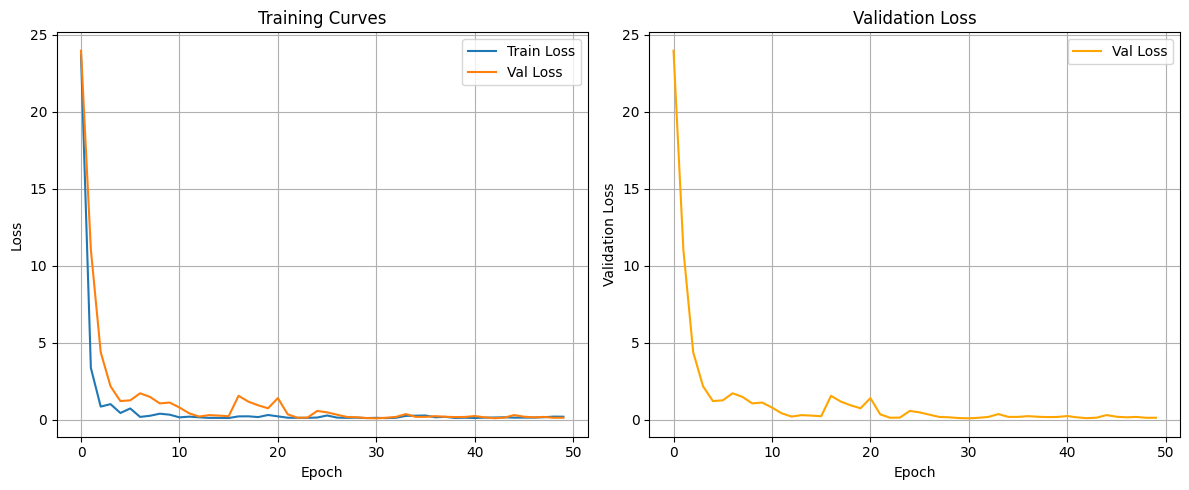


✓ Training completed successfully!
Best validation loss: 0.0798
Model saved to: /kaggle/working/yolomaml_output


In [ ]:
if __name__ == '__main__':
    print("\n" + "="*80)
    print("YOLOMAML Pipeline - Ready!")
    print("="*80)

    # Show GPU status
    monitor_gpu_usage()

    # Example: Train the model
    print("\n" + "="*80)
    print("Starting Training")
    print("="*80)

    trainer = main_training()

    if trainer is not None:
        print("\n✓ Training completed successfully!")
        print(f"Best validation loss: {trainer.best_val_loss:.4f}")
        print(f"Model saved to: {cfg.OUTPUT_DIR}")

In [ ]:
# Thêm cell này để kiểm tra cấu trúc dữ liệu
import os

print("Checking data structure...")
print("="*80)

# Kiểm tra thư mục dataset
DATASET_DIR = '/kaggle/input/raw-data/train'
print(f"\n1. Dataset directory exists: {os.path.exists(DATASET_DIR)}")

if os.path.exists(DATASET_DIR):
    print(f"\nContents of {DATASET_DIR}:")
    for item in os.listdir(DATASET_DIR):
        print(f"  - {item}")

    # Kiểm tra annotations
    annotations_path = os.path.join(DATASET_DIR, 'annotations', 'annotations.json')
    print(f"\n2. Annotations file exists: {os.path.exists(annotations_path)}")

    # Kiểm tra samples directory
    samples_dir = os.path.join(DATASET_DIR, 'samples')
    print(f"\n3. Samples directory exists: {os.path.exists(samples_dir)}")

    if os.path.exists(samples_dir):
        sample_folders = os.listdir(samples_dir)
        print(f"\n4. Number of video folders: {len(sample_folders)}")

        # Kiểm tra cấu trúc của 1 video folder
        if len(sample_folders) > 0:
            first_video = sample_folders[0]
            video_path = os.path.join(samples_dir, first_video)
            print(f"\n5. Checking structure of '{first_video}':")
            for item in os.listdir(video_path):
                print(f"  - {item}")

            # Kiểm tra object_images
            obj_img_dir = os.path.join(video_path, 'object_images')
            if os.path.exists(obj_img_dir):
                print(f"\n6. Reference images in 'object_images':")
                for img in os.listdir(obj_img_dir):
                    img_path = os.path.join(obj_img_dir, img)
                    print(f"  - {img} (exists: {os.path.exists(img_path)})")

print("\n" + "="*80)

Checking data structure...

1. Dataset directory exists: True

Contents of /kaggle/input/raw-data/train:
  - samples
  - annotations

2. Annotations file exists: True

3. Samples directory exists: True

4. Number of video folders: 14

5. Checking structure of 'MobilePhone_1':
  - drone_video.mp4
  - object_images

6. Reference images in 'object_images':
  - img_2.jpg (exists: True)
  - img_3.jpg (exists: True)
  - img_1.jpg (exists: True)



In [ ]:
def run_complete_inference():
    """Run complete inference pipeline"""

    # Define paths
    MODEL_PATH = os.path.join(cfg.OUTPUT_DIR, 'prototypical_best.pt')
    TEST_DIR = '/kaggle/input/public-test/public_test/samples'
    OUTPUT_JSON = 'yolomaml_predictions.json'

    # Check if model exists
    if not os.path.exists(MODEL_PATH):
        print(f"Error: Model not found at {MODEL_PATH}")
        print("Please train the model first!")
        return

    # Run inference
    print("\nRunning Few-Shot Inference...")
    predictions = few_shot_inference(
        model_path=MODEL_PATH,
        test_video_dir=TEST_DIR,
        output_json=OUTPUT_JSON,
        confidence=0.1
    )

    # Final summary
    print("\n" + "="*80)
    print("INFERENCE SUMMARY")
    print("="*80)
    print(f"✓ Predictions saved to: {OUTPUT_JSON}")
    print(f"✓ Total videos processed: {len(predictions)}")

    # Count detections
    total_detections = sum(
        len(ann['bboxes'])
        for v in predictions
        for ann in v['annotations']
    )
    print(f"✓ Total detections: {total_detections}")

    # Per-video breakdown
    print(f"\nPer-video detections:")
    for v in predictions:
        det_count = sum(len(ann['bboxes']) for ann in v['annotations'])
        print(f"  • {v['video_id']}: {det_count} detections")

    print("="*80)

    return predictions

In [21]:
predictions = run_complete_inference()


Running Few-Shot Inference...
YOLOMAML Few-Shot Inference

[1/4] Loading model...

[2/4] Finding test videos...
Found 6 test videos

[3/4] Processing videos...


Inference:   0%|          | 0/6 [00:00<?, ?it/s]


📹 BlackBox_0: 0/5443 detections

📹 BlackBox_1: 0/5776 detections

📹 CardboardBox_0: 0/5285 detections

📹 CardboardBox_1: 0/5942 detections

📹 LifeJacket_0: 0/8309 detections

📹 LifeJacket_1: 0/4820 detections

[4/4] Saving predictions to yolomaml_predictions.json...

✓ Inference complete!

INFERENCE SUMMARY
✓ Predictions saved to: yolomaml_predictions.json
✓ Total videos processed: 6
✓ Total detections: 0

Per-video detections:
  • BlackBox_0: 0 detections
  • BlackBox_1: 0 detections
  • CardboardBox_0: 0 detections
  • CardboardBox_1: 0 detections
  • LifeJacket_0: 0 detections
  • LifeJacket_1: 0 detections


In [ ]:
def compute_iou(box1, box2):
    """Compute IoU between two boxes"""
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # Intersection
    xi_min = max(x1_min, x2_min)
    yi_min = max(y1_min, y2_min)
    xi_max = min(x1_max, x2_max)
    yi_max = min(y1_max, y2_max)

    inter_area = max(0, xi_max - xi_min) * max(0, yi_max - yi_min)

    # Union
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area > 0 else 0
    return iou


def evaluate_predictions(pred_file, gt_file, iou_threshold=0.5):
    """Evaluate predictions against ground truth"""
    with open(pred_file, 'r') as f:
        predictions = json.load(f)

    with open(gt_file, 'r') as f:
        ground_truths = json.load(f)

    # Create video_id mapping
    pred_dict = {p['video_id']: p for p in predictions}
    gt_dict = {g['video_id']: g for g in ground_truths}

    total_tp = 0
    total_fp = 0
    total_fn = 0

    for video_id in gt_dict.keys():
        if video_id not in pred_dict:
            # Count all GT as FN
            for interval in gt_dict[video_id].get('annotations', []):
                total_fn += len(interval.get('bboxes', []))
            continue

        gt_bboxes = []
        for interval in gt_dict[video_id].get('annotations', []):
            for bbox in interval.get('bboxes', []):
                gt_bboxes.append({
                    'frame': bbox['frame'],
                    'box': [bbox['x1'], bbox['y1'], bbox['x2'], bbox['y2']]
                })

        pred_bboxes = []
        for detection in pred_dict[video_id].get('detections', []):
            for bbox in detection.get('bboxes', []):
                pred_bboxes.append({
                    'frame': bbox['frame'],
                    'box': [bbox['x1'], bbox['y1'], bbox['x2'], bbox['y2']]
                })

        # Match predictions to ground truths
        matched_gt = set()

        for pred in pred_bboxes:
            matched = False
            for i, gt in enumerate(gt_bboxes):
                if gt['frame'] == pred['frame'] and i not in matched_gt:
                    iou = compute_iou(pred['box'], gt['box'])
                    if iou >= iou_threshold:
                        total_tp += 1
                        matched_gt.add(i)
                        matched = True
                        break

            if not matched:
                total_fp += 1

        total_fn += len(gt_bboxes) - len(matched_gt)

    # Compute metrics
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print("\n" + "="*80)
    print("Evaluation Results")
    print("="*80)
    print(f"True Positives: {total_tp}")
    print(f"False Positives: {total_fp}")
    print(f"False Negatives: {total_fn}")
    print(f"\nPrecision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': total_tp,
        'fp': total_fp,
        'fn': total_fn
    }


print("\n" + "="*80)
print("YOLOMAML Pipeline Complete!")
print("="*80)
print("\nUsage:")
print("1. Train: trainer = main_training()")
print("2. Inference: predictions = run_complete_inference()")
print("3. Visualize: visualize_support_set('drone_video_001', TEST_DIR)")
print("4. Evaluate: evaluate_predictions('predictions.json', 'gt.json')")


YOLOMAML Pipeline Complete!

Usage:
1. Train: trainer = main_training()
2. Inference: predictions = run_complete_inference()
3. Visualize: visualize_support_set('drone_video_001', TEST_DIR)
4. Evaluate: evaluate_predictions('predictions.json', 'gt.json')
